# 1. Importación de librerías y carga de datos

In [1]:
SCALED=False
STANDARIZED=False

In [2]:
import pandas as pd
import numpy as np
import pickle
import os

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

C:\Users\sandr\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
df = pd.read_csv('positions.csv')
df.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id,victim_id,shape_collider,shape_victim,latitude(m),longitude(m),speed(m/s),heading,acceleration(m/s²),collision
0,1.0,0,-1,passenger,-1,41.402717,2.137950,14.7234,137.798227,0.0,0
1,1.0,200,-1,delivery,-1,41.401891,2.146248,0.0000,126.656286,0.0,0
2,1.0,201,-1,motorcycle,-1,41.396495,2.159059,0.0000,253.423078,0.0,0
3,1.0,202,-1,passenger,-1,41.393329,2.148322,0.0000,318.602899,0.0,0
4,1.0,203,-1,delivery,-1,41.391727,2.154971,0.0000,316.186762,0.0,0


In [4]:
df = df.sort_values(['vehicle_id', 'time(s)'], ignore_index=True)
columns = ['time(s)', 'vehicle_id', 'latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
df = df[columns]
df.head()

,time(s),vehicle_id,latitude(m),longitude(m),heading,speed(m/s),acceleration(m/s²)
0,1.0,0,41.402717,2.137950,137.798227,14.723400,0.000000
1,2.0,0,41.402633,2.138082,128.510085,14.418443,-0.304957
2,3.0,0,41.402549,2.138213,128.510085,14.193703,-0.224740
3,4.0,0,41.402468,2.138340,135.176752,13.853303,-0.340400
4,5.0,0,41.402378,2.138462,135.176752,14.350286,0.496983


In [6]:
# Load dataset with vehicles colision
df_col = pd.read_csv('collisions_2k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,863,300
1,8573,8361
2,8745,8517
3,6756,719
4,8104,9096


In [7]:
df_nocol = pd.read_csv('no_collisions_2k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,31477,34003
1,33063,33228
2,33130,33973
3,33268,33958
4,33268,34256


## 2. Preprocesamiento de los datos

In [8]:
if SCALED:
    # MinMax scaler for features
    minmaxscaler = MinMaxScaler()
    scaled_features = minmaxscaler.fit_transform(df.iloc[:, 2:])

    # Save scaler for future uses
    minmaxscaler_file = os.path.join('./',
                                   "minmaxscaler.pkl")
    with open(minmaxscaler_file, "wb") as f_scaler:
        pickle.dump(minmaxscaler, f_scaler)

    # Generate scaled dataset
    scaled_features = pd.DataFrame(
        scaled_features, columns=minmaxscaler.get_feature_names_out())
    df_scaled = pd.concat([df.iloc[:, :2], scaled_features], axis=1)
    print(df_scaled.shape)
    print(df_scaled.head())
    
elif STANDARIZED:
  # Standarization of features
    standardscaler = StandardScaler()
    stand_features = standardscaler.fit_transform(df.iloc[:, 2:])

    # Save standarscaler for future uses
    standardscaler_file = os.path.join('./',
                                     "standardscaler.pkl")
    with open(standardscaler_file, "wb") as f_scaler:
        pickle.dump(standardscaler, f_scaler)

    # Generate standarized dataset
    stand_features = pd.DataFrame(
        stand_features, columns=standardscaler.get_feature_names_out())
    df_stand = pd.concat([df.iloc[:, :2], stand_features], axis=1)
    print(df_stand.shape)
    print(df_stand.head())

In [9]:
# Generate list with vehicle_id for testing dataset
v1_col_set = set(df_col.loc[:, 'vehicle_id'])
v2_col_set = set(df_col.loc[:, 'victim_id'])
vehicle_col_set = v1_col_set | v2_col_set
print(len(vehicle_col_set))

v1_nocol_set = set(df_nocol.loc[:, 'v1'])
v2_nocol_set = set(df_nocol.loc[:, 'v2'])
vehicle_nocol_set = v1_nocol_set | v2_nocol_set
print(len(vehicle_nocol_set))

vehicle_id_test = vehicle_col_set | vehicle_nocol_set
print(len(vehicle_id_test))

1827
839
2402


## 3. Generación de ventanas

In [10]:
# Input and output columns
INPUT_COL = ['time(s)', 'latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['time(s)', 'latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']


class WindowGenerator():
    input_columns = []
    output_columns = []
    input_columns_filter = []
    output_columns_filter = []

    total_window_size = 0

    input_slice = None
    input_indices = []
    output_slice = None
    output_indices = []

    def __init__(self, input_width, output_width, offset_width, dataset,
               input_columns=None, output_columns=None):
        # Work out the input and output column filters.
        self.input_columns = input_columns
        if input_columns:
            self.input_columns_filter = [col in input_columns 
                                         for col in dataset.columns]

        self.output_columns = output_columns
        if output_columns:
            self.output_columns_filter = [col in output_columns 
                                          for col in dataset.columns]

        # Work out the window parameters.
        self.total_window_size = input_width + offset_width + output_width

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        output_start = input_width + offset_width
        self.output_slice = slice(output_start, None)
        self.output_indices = np.arange(self.total_window_size)[self.output_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Output indices: {self.output_indices}',
            f'Input column name(s): {self.input_columns}',
            f'Output column name(s): {self.output_columns}'])


    def split_window(self, dataset, shift):
        inputs_list, outputs_list = list(), list()

        for i in range(len(dataset)):
            start = len(dataset) - ((i+1)*shift)
            end = len(dataset) - (i*shift)
            if start < 0:
                break
            window_data = np.array(dataset[start:end], dtype=np.float64)

            # Gather input and output parts of the pattern
            inputs = window_data[self.input_slice, :]
            if self.input_columns_filter:
                inputs = inputs[:, self.input_columns_filter]
                inputs_list.append(inputs)

            outputs = window_data[self.output_slice, :]
            if self.output_columns_filter:
                outputs = outputs[:, self.output_columns_filter]
                outputs_list.append(outputs)

        return np.array(inputs_list, dtype=np.float64), \
        np.array(outputs_list, dtype=np.float64)


def make_windowed_dataset(dataset, input_width, output_width, offset_width,
                          shift, id_test_list, input_columns=None,
                      output_columns=None):
    X = np.empty((0, input_width, len(input_columns)-1), dtype=np.float64)
    y = np.empty((0, output_width, len(output_columns)-1), dtype=np.float64)
    X_test = np.empty((0, input_width, len(input_columns)-1), dtype=np.float64)
    y_test = np.empty((0, output_width, len(output_columns)-1), dtype=np.float64)
    vehicle_ids = []

    # Generate time window
    # df_vehicles = dataset.sort_values(by=['vehicle_id', 'time(s)'])
    time_window = WindowGenerator(
        input_width=input_width, output_width=output_width, offset_width=offset_width,
        dataset=dataset.drop('vehicle_id', axis=1),
        input_columns=input_columns, output_columns=output_columns)
    print(time_window)

    # Generate windowed dataset
    print(len(dataset['vehicle_id'].unique()))
    cont = 1
    for id in dataset['vehicle_id'].unique():
        if cont%1000 == 0:
            print(cont)
        vehicle_df = (dataset[dataset['vehicle_id'] == id]
                      .drop('vehicle_id', axis=1))
        inputs, labels = time_window.split_window(vehicle_df, shift)
        if np.any(inputs) and np.any(labels):
            inputs = np.flip(inputs, axis=0)
            labels = np.flip(labels, axis=0)
            if id in id_test_list:
                if len(inputs) > 1:
                    # Get n-1 training windows
                    X = np.vstack((X, inputs[:-1, :, 1:])) # latitude, longitude and heading
                    y = np.vstack((y, labels[:-1, :, 1:])) # latitude, longitude and heading

                    # Get a testing window
                    X_test = np.vstack((X_test, inputs[-1:, :, 1:]))
                    y_test = np.vstack((y_test, labels[-1:, :, 1:]))

                    # Generate list with testing vehicle ids
                    vehicle_ids.append(id)
                else:
                    # Get a testing window
                    X_test = np.vstack((X_test, inputs[:, :, 1:]))
                    y_test = np.vstack((y_test, labels[:, :, 1:]))

                    # Generate list with testing vehicle ids
                    vehicle_ids.append(id)
            else:
                # Get n training windows
                X = np.vstack((X, inputs[:, :, 1:])) # latitude, longitude and heading
                y = np.vstack((y, labels[:, :, 1:])) # latitude, longitude and heading

        cont = cont+1

    return X, y, X_test, y_test, vehicle_ids


def train_val_split(X, y, val_size, filename=None):
    X_train, X_val, y_train, y_val = [], [], [], []

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size,
                                                    random_state=0)

    if filename:
        np.savez(filename,
                 X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

    return X_train, X_val, y_train, y_val

### 3.1. Ventana no coincidente multi-step (input_step = 20s, output_step = 5s)

In [11]:
# Window parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0
SHIFT=INPUT_WIDTH + OUTPUT_WIDTH + OFFSET_WIDTH

# Generate windows
if SCALED:
    X, y, X_test, y_test, vehicle_ids = make_windowed_dataset(
        df_scaled, input_width=INPUT_WIDTH, output_width=OUTPUT_WIDTH,
        offset_width=OFFSET_WIDTH, shift=SHIFT, id_test_list=vehicle_id_test,
        input_columns=INPUT_COL, output_columns=OUTPUT_COL)
elif STANDARIZED:
    X, y, X_test, y_test, vehicle_ids = make_windowed_dataset(
        df_stand, input_width=INPUT_WIDTH, output_width=OUTPUT_WIDTH,
        offset_width=OFFSET_WIDTH, shift=SHIFT, id_test_list=vehicle_id_test,
        input_columns=INPUT_COL, output_columns=OUTPUT_COL)
else:
    X, y, X_test, y_test, vehicle_ids = make_windowed_dataset(
        df, input_width=INPUT_WIDTH, output_width=OUTPUT_WIDTH,
        offset_width=OFFSET_WIDTH, shift=SHIFT, id_test_list=vehicle_id_test,
        input_columns=INPUT_COL, output_columns=OUTPUT_COL)

print("\nWindowed dataset dimesions:\nX: {}  y: {}\nX_test: {}  y_test: {}\n"
      .format(X.shape, y.shape, X_test.shape, y_test.shape))

# Save testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, "wb") as f_vehicle_ids:
    pickle.dump(vehicle_ids, f_vehicle_ids)

# Save testing dataset as compressed numpy file
if SCALED:
    test_file = os.path.join('./',
                             "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    test_file = os.path.join('./',
                             "ventanas_no_coincidentes_test_stand.npz")
else:
    test_file = os.path.join('./',
                             "ventanas_no_coincidentes_test.npz")
np.savez(test_file, X_test=X_test, y_test=y_test)

# Generate training and validation datasets and save them as a compressed numpy
# file
if SCALED:
    ds_file = os.path.join('./',"ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    ds_file = os.path.join('./',
                           "ventanas_no_coincidentes_train_val_stand.npz")
else:
    ds_file = os.path.join('./',
                           "ventanas_no_coincidentes_train_val.npz")
    
X_train, X_val, y_train, y_val = train_val_split(X, y, val_size=0.3,
                                                 filename=ds_file)

print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Output indices: [20 21 22 23 24]
Input column name(s): ['time(s)', 'latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
Output column name(s): ['time(s)', 'latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
107476
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
10

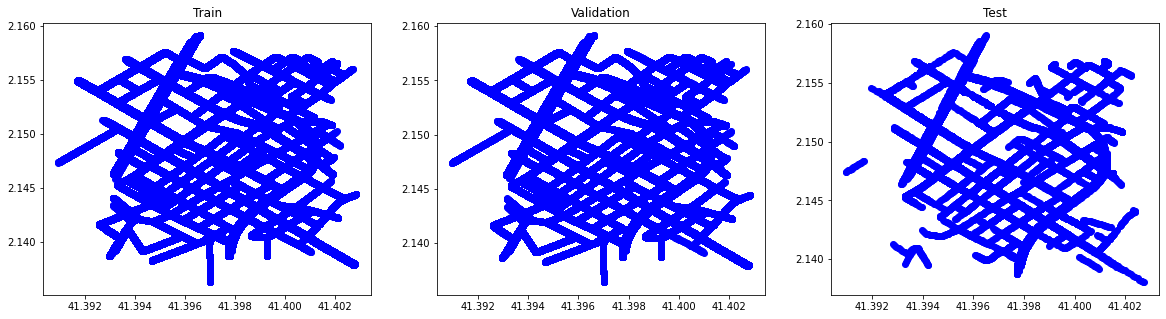

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(X_train[:, :, 0], X_train[:, :, 1], 'bo')
ax[0].title.set_text("Train")
ax[1].plot(X_val[:, :, 0], X_val[:, :, 1], 'bo')
ax[1].title.set_text("Validation")
ax[2].plot(X_test[:, :, 0], X_test[:, :, 1], 'bo')
ax[2].title.set_text("Test")
plt.show()

In [13]:
print("X_train: ", X_train.min(axis=0).min(axis=0), X_train.max(axis=0).max(axis=0))
print("X_val:   ", X_val.min(axis=0).min(axis=0), X_val.max(axis=0).max(axis=0))
print("X_test:  ", X_test.min(axis=0).min(axis=0), X_test.max(axis=0).max(axis=0))

X_train:  [ 4.13909201e+01  2.13627129e+00  1.65682045e-04  0.00000000e+00
 -1.00000000e+01] [ 41.40285198   2.15913705 359.99990161  19.32365767   5.99999783]
X_val:    [ 4.13909469e+01  2.13639576e+00  2.05224393e-05  0.00000000e+00
 -1.00000000e+01] [ 41.40285198   2.15913705 359.99968513  19.29271108   5.99997184]
X_test:   [ 41.39094833   2.1380169    0.50156013   0.         -10.        ] [ 41.40274864   2.15903389 359.95449606  17.84668837   5.99827646]
